<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Lanngraph_corrective_rag_self_rag_and_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook we will try to create the production ready different RAG approaches that langgraph supports

### We will start with creating a corrective rag which will grade the document and generate the best answer

In [ ]:
pip install tavily-python langchain-tavily


In [ ]:
pip install langchain langgraph langchain-core langchain-community langchain-groq langchain faiss-cpu langchain-huggingface

In [3]:
# let us understand how the document grader works first by creating the retriever using faiss

from langchain_community.document_loaders import TextLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_tavily import TavilySearch


In [4]:
loader=TextLoader("/content/nepal_insurance_details.txt")
docs=loader.load()

In [ ]:
embeddings=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

In [6]:
text_splitter=RecursiveCharacterTextSplitter(chunk_overlap=200, chunk_size=800,separators=["\n\n","\n"])
chunk=text_splitter.split_documents(docs)
vector_stores=FAISS.from_documents(chunk, embeddings)

In [7]:
retriever=vector_stores.as_retriever(search_kwargs={"k":4})

In [8]:
result=retriever.invoke("What is the document about?")

In [9]:
print(result)

[Document(id='1f2c436d-da46-4ad4-9ed1-6f7c57babdab', metadata={'source': '/content/nepal_insurance_details.txt'}, page_content='Enrollment Procedure\nCitizens enroll via local Enrollment Assistants (volunteers) at ward offices, health posts, or empaneled facilities using the Insurance Management Information System (IMIS). Provide citizenship certificate, photos, and pay NPR 3,500 annually for a standard family (recent figure); receive a health insurance card instantly or shortly after.'), Document(id='0bda86fa-c210-47ac-9d47-84e41401ef36', metadata={'source': '/content/nepal_insurance_details.txt'}, page_content='Description of the tests provided free of charge by specific government programs (outside of the standard Health Insurance Board coverage) are:'), Document(id='55102e7f-4fd7-4fd2-adf2-ed0dc93e6e4d', metadata={'source': '/content/nepal_insurance_details.txt'}, page_content='Pay Co-Pay: Cover 20% of approved costs immediately (e.g., NPR 200 on a NPR 1,000 bill); no upfront payme

In [ ]:
for doc in result:
  print(doc.id)
  print(doc.metadata)
  print(doc.page_content)
  print("\n\n-------")

## This is the data that we get from the retriever, now we will use this data to check if it is correct or not than only we will go with the generation ,hence this is the implementation of the corrective rag

# Using and settin up the data now

In [11]:
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph , START , END
from langgraph.prebuilt import ToolNode
from typing import Literal
from langchain_core.tools import tool
from pydantic import BaseModel , Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.output_parsers import StrOutputParser

In [12]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')
tavily_api_key=userdata.get('Tavily_api_key')

In [13]:
llm=ChatGroq(model="openai/gpt-oss-20b",api_key=api_key)
memory=MemorySaver()

In [14]:
class AgentState(MessagesState):
  document:list[str]
  web_search:str

In [15]:
class GradeDocument(BaseModel):
  binary_score:Literal["yes","no"]=Field(description="Choose yes or no based the user question  related to medical or not")

In [16]:
llm_with_structured_output=llm.with_structured_output(GradeDocument)

In [17]:
system="""You are an assistant used for grading the document and the user question are related with each other or not , if related than
set it as 'yes' else 'no' based on the document provided by the user"""
prompt=ChatPromptTemplate([
    ("system",system),
    ("human","Based on this document{document} for this question {question}")
])
retreiver_grader=prompt | llm_with_structured_output

In [18]:
system_2="""You are an advance query rewriter that transform the user query to the best query for tavily search first understand the user query and generate the best alternative, rewrite the question closer to the acutal one"""
prompt_query_rewriter=ChatPromptTemplate([
    ("system",system_2),
    ("human","Generate the best question for this {question}")
])
query_rewriter=prompt_query_rewriter|llm|StrOutputParser()


In [19]:
system_3="""You are an advance answer generator, generate the best answer on the given question using the available document"""
prompt_llm_generator=ChatPromptTemplate(
    [
        ("system",system_3),
        ("user","Document {document} and question is {question}\n")
    ]
)
llm_generator=prompt_llm_generator|llm|StrOutputParser()

In [20]:
def retriever_rag(state:AgentState):
  query=state["messages"][-1].content
  docs=retriever.invoke(query)
  return {"document":docs}


In [21]:
def router1(state:AgentState)->Literal["generator","query_rewriter"]:
  user_query=state["messages"][-1].content
  docs=state["document"]
  filtered_docs=[]
  for doc in docs:
    filtered_docs.append(doc.page_content)
  actual_text="\n".join(doc for doc in filtered_docs)
  response=retreiver_grader.invoke({"question":{user_query},"document":{actual_text}})
  if response.binary_score== "yes":
    return "generator"
  else:
    print("returning query_rewriter")
    return "query_rewriter"


In [22]:
def query_rewriter(state:AgentState):
  user_query=state["messages"][-1].content
  new_query=query_rewriter.invoke({"question":{user_query}})
  return {"messages":[new_query]}

In [23]:
tavily_search=TavilySearch(tavily_api_key=tavily_api_key)

In [24]:
def websearch(state:AgentState):
  message=state["messages"][-1]
  response=tavily_search.invoke(message.content)
  return {"document":[response],"web_search":"yes"}



In [25]:
def generate(state:AgentState):
  response_source=state.get("websearch","no")
  print(response_source)
  query=state["messages"][-1]
  document=state["document"]
  if response_source == "yes":
    response=llm_generator.invoke({"question":query, "document":document})
  else:
    filtered_docs=[]
    for doc in document:
      filtered_docs.append(doc.page_content)
    actual_text="\n".join(doc for doc in filtered_docs)
    response=llm_generator.invoke({"question":query,"document":actual_text})
    print(response)
    return {"messages":[response]}



In [26]:
workflow=StateGraph(AgentState)
workflow.add_node("retriever",retriever_rag)
workflow.add_node("query_rewriter",query_rewriter)
workflow.add_node("websearch",websearch)
workflow.add_node("generator",generate)
workflow.add_edge(START, "retriever")
workflow.add_conditional_edges("retriever",router1,{"generator":"generator","query_rewriter":"query_rewriter"})
workflow.add_edge("query_rewriter","websearch")
workflow.add_edge("websearch","generator")
workflow.add_edge("generator",END)
app=workflow.compile(checkpointer=memory)


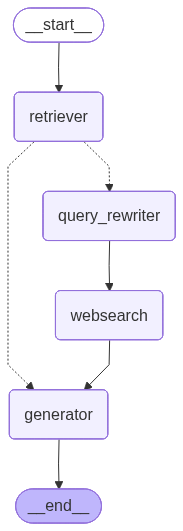

In [27]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [28]:
config={"configurable":{"thread_id":"1"}}

In [ ]:
response=app.invoke({"messages":"How can i do goverment insurance in Nepal?"},config=config)

### New Task is to use the agent with memory 😿😿🔦🔦🔦 , so that the agent will remember all the past chat messages

In [36]:
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain_community.document_loaders import TextLoader
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START , END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_tavily import TavilySearch

In [37]:
from google.colab import userdata
tavily_api_key=userdata.get('Tavily_api_key')
api_key=userdata.get('groq_api_key')


In [38]:
llm=ChatGroq(model="openai/gpt-oss-120b",api_key=api_key)

In [39]:
tavily_search= TavilySearch(tavily_api_key=tavily_api_key)

In [ ]:
class AgentState(MessagesState):
